# Amazon Review Rating Classifier
### CMPE 462, Spring 2018

In this NLP project, we found Amazon product review data from Kaggle. In this dataset, there are two columns, namely the comments and the corresponding ratings. The ratings are either positive or negative so this is a binary classification problem. Three star comments are eliminated, one and two star ratings are merged together as the negative reviews and four and five star ratings make up the positive reviews. 

Our dataset consists of 400K product reviews.

Dataset: https://www.kaggle.com/bittlingmayer/amazonreviews/data

In [ ]:
%% script false
import nltk
from nltk.corpus import stopwords
import string

This cell is used to preprocess the dataset. Punctuation marks and stopwords (trivial words like a, the, etc.) are eliminated and all words are turned into lowercase so that it will be more accurate to count the frequencies of the words in the future. 

In [ ]:
%% script false
punctuationSet = set(list(string.punctuation))
stopWordsSet = set(stopwords.words("english"))

with open("dataset.csv","w") as outfile:
    with open("amazonreviews/test.txt","r") as infile:
        outfile.write('"Review Rating","Review Text"\n')
        for line in infile:

            line = "".join([char for char in line if char not in punctuationSet])
            line = " ".join([word for word in line.split() if word.lower() not in stopWordsSet])
            parts = line.split(" ",1)
            line =  '"' + str(int(parts[0][5]) - 1) + '","' + parts[1] + '"\n'
            outfile.write(line.lower())
        

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def averageWordLength(line):
    return len(line)/line.count(" ")

fullData = pd.read_csv("dataset.csv")

#split dataset into 80% train and 20% test data
trainData, testData = train_test_split(fullData, test_size=0.2)


In [3]:
fullData.head()

,Review Rating,Review Text
0,1,great cd lovely pat one great voices generatio...
1,1,one best game music soundtracks game didnt rea...
2,0,batteries died within year bought charger jul ...
3,1,works fine maha energy better check maha energ...
4,1,great nonaudiophile reviewed quite bit combo p...


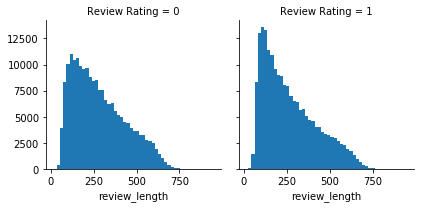

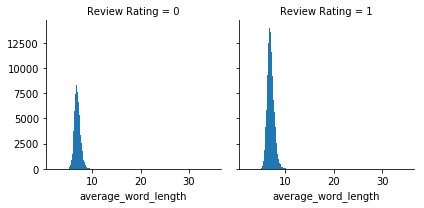

In [4]:
#see if these futures are any use

fullData["average_word_length"] =  fullData["Review Text"].apply(averageWordLength)
fullData["review_length"] =  fullData["Review Text"].apply(len)

p = sb.FacetGrid(data=fullData, col="Review Rating")
p.map(plt.hist, "review_length", bins = 50)

p = sb.FacetGrid(data=fullData, col="Review Rating")
p.map(plt.hist, "average_word_length", bins = 300)



In [5]:
from wordcloud import WordCloud, STOPWORDS

pos_words = fullData.loc[fullData['Review Rating'] == 1]['Review Text']
neg_words = fullData.loc[fullData['Review Rating'] == 0]['Review Text']

p_list = set([])
n_list = set([])

for p, n in zip(pos_words, neg_words):
    p_list.update(p.split())
    n_list.update(n.split())
    
commonwords = STOPWORDS.union(p_list & n_list)

def draw_wordcloud(words, sw, color):
    words = " ".join(words)
    wordcloud = WordCloud(stopwords=sw,
                          background_color=color,
                      width=2500,
                      height=2000
                     ).generate(words)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    

In [ ]:
#plot wordcloud for words that are most associated with being positive or negative
plt.figure(figsize=(20,60))
plt.subplot(1, 2, 1)
draw_wordcloud(pos_words, STOPWORDS, 'white')
plt.subplot(1, 2, 2)
draw_wordcloud(neg_words, STOPWORDS, 'black')
plt.show()

In [ ]:
#plot wordcloud for UNIQUE words that are most associated with being positive or negative
plt.figure(figsize=(20,60))
plt.subplot(1, 2, 1)
draw_wordcloud(pos_words, commonwords, 'white')
plt.subplot(1, 2, 2)
draw_wordcloud(neg_words, commonwords, 'black')
plt.show()

## Naive Bayes

In [7]:
#Map every word to number of times it is used in the database

freqMap = {}

for l in trainData["Review Text"]:
    for w in l.split():
        if w not in freqMap:
            freqMap[w] = 1
        else:
            freqMap[w] += 1

len(freqMap)

421493

In [8]:
#Set of words that are going to be used in the algorithm

wordSet = set([])

for key in freqMap:
    if freqMap[key]>100:
        wordSet.add(key)

len(wordSet)

10012

In [9]:
rateOfPositiveData = len([rating for rating in trainData['Review Rating'] if rating==1]) / len(trainData['Review Rating'])

#Maps every word to number of occurrence of the word in positive reviews
freqInPositiveReviews = {}

#Maps every word to number of occurrence of the word in negative reviews
freqInNegativeReviews = {}

totalNumOfWordsInPositiveReviews = 0
totalNumOfWordsInNegativeReviews = 0

for w in wordSet:
    freqInPositiveReviews[w] = 0
    freqInNegativeReviews[w] = 0


for d in trainData.itertuples():
    if d[1] == 1:
        for w in [word for word in d[2].split() if word in wordSet]:
            freqInPositiveReviews[w]+=1
            totalNumOfWordsInPositiveReviews+=1
    else:
        for w in [word for word in d[2].split() if word in wordSet]:
            freqInNegativeReviews[w]+=1
            totalNumOfWordsInNegativeReviews+=1


            
rate1Map = {}
rate0Map = {}

for word in wordSet:
    rate1Map[word] = freqInPositiveReviews[word]/totalNumOfWordsInPositiveReviews
    rate0Map[word] = freqInNegativeReviews[word]/totalNumOfWordsInNegativeReviews


In [10]:
def predictReviewWithBayes(text, verbose=False):
    wordList = [word for word in text.split() if word in wordSet]
    p1 = 0
    p0 = 0
    for w in wordList:
        if verbose:
            print(w, rate1Map[w], rate0Map[w])
        p1 += np.log(rate1Map[w])
        p0 += np.log(rate0Map[w])
    if verbose:
        print(p1,p0)
    if (p1 * rateOfPositiveData) > (p0 * (1 - rateOfPositiveData)):
        return 1
    else:
        return 0


print("positive test:", predictReviewWithBayes("I love this product it is amazing love so much wow", True))
print()
print("negative test:", predictReviewWithBayes("disgusting ew hate it so much omg", True))

love 0.005652239281980067 0.0016223221296145039
product 0.0025561059110806523 0.004078769854855753
amazing 0.0012572965525058483 0.00020003536369507882
love 0.005652239281980067 0.0016223221296145039
much 0.0035646866080951056 0.004180554039074023
wow 0.0003349902959303552 0.00016941598926908694
-36.637556852793246 -41.02723460480535
positive test: 1

disgusting 1.2814822743025443e-05 0.00011070081523243217
hate 0.00020178833558735838 0.00045474818172228597
much 0.0035646866080951056 0.004180554039074023
omg 1.931247934512285e-05 2.7086369684531276e-05
-36.26463749356042 -32.79823750919608
negative test: 0


Accuracy of Naive Bayes: 0.8476625


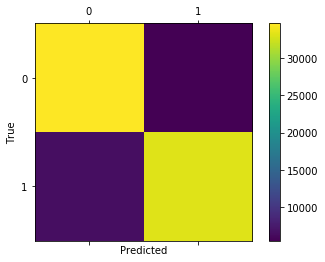

             precision    recall  f1-score   support

          0       0.84      0.86      0.85     40132
          1       0.86      0.83      0.84     39868

avg / total       0.85      0.85      0.85     80000



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
def metrics():
    trueGuesses = 0
    allGuesses = 0
    
    truths = []
    preds = []
    for _, rating, text in testData.itertuples():
        prediction = predictReviewWithBayes(text, False)
        if rating == prediction:
            trueGuesses+=1
        truths.append(rating)
        preds.append(prediction)
        allGuesses+=1
    return trueGuesses, allGuesses, confusion_matrix(truths, preds), classification_report(truths, preds)

trueGuesses, allGuesses, cm, report = metrics()
print("Accuracy of Naive Bayes:", trueGuesses/allGuesses)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(report)

## LSTM

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

/Users/ezgitek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
max_data_count = 10000
data = fullData.iloc[:max_data_count]

tokenizer = Tokenizer(num_words=100, split=' ')
tokenizer.fit_on_texts(data['Review Text'].values)
X = tokenizer.texts_to_sequences(data['Review Text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['Review Rating']).values

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [16]:
np.shape(X_train),np.shape(Y_train),np.shape(X_test),np.shape(Y_test)

((8000, 44), (8000, 2), (2000, 44), (2000, 2))

In [17]:
embed_dim = 128
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(Embedding(100, embed_dim,input_length = X_train.shape[1], dropout = 0.2))
model.add(LSTM(lstm_out, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

/Users/ezgitek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 44, 128)           12800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 276,402
Trainable params: 276,402
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
history = model.fit(X_train, Y_train, batch_size=32, epochs = 20,  verbose = 2)

Epoch 1/20
 - 20s - loss: 0.5233 - acc: 0.7396
Epoch 2/20
 - 25s - loss: 0.5168 - acc: 0.7445
Epoch 3/20
 - 24s - loss: 0.5131 - acc: 0.7439
Epoch 4/20
 - 21s - loss: 0.5093 - acc: 0.7464
Epoch 5/20
 - 20s - loss: 0.5025 - acc: 0.7454
Epoch 6/20
 - 20s - loss: 0.4959 - acc: 0.7484
Epoch 7/20
 - 23s - loss: 0.4911 - acc: 0.7520
Epoch 8/20
 - 19s - loss: 0.4863 - acc: 0.7556
Epoch 9/20
 - 25s - loss: 0.4780 - acc: 0.7632
Epoch 10/20
 - 24s - loss: 0.4749 - acc: 0.7661
Epoch 11/20
 - 27s - loss: 0.4644 - acc: 0.7661
Epoch 12/20
 - 26s - loss: 0.4535 - acc: 0.7771
Epoch 13/20
 - 21s - loss: 0.4425 - acc: 0.7844
Epoch 14/20
 - 9s - loss: 0.4336 - acc: 0.7884
Epoch 15/20
 - 18s - loss: 0.4193 - acc: 0.7949
Epoch 16/20
 - 18s - loss: 0.4108 - acc: 0.8033
Epoch 17/20
 - 18s - loss: 0.3915 - acc: 0.8129
Epoch 18/20
 - 18s - loss: 0.3776 - acc: 0.8207
Epoch 19/20
 - 18s - loss: 0.3540 - acc: 0.8354
Epoch 20/20
 - 18s - loss: 0.3341 - acc: 0.8441


In [20]:
score, accuracy = model.evaluate(X_test, Y_test, verbose=2, batch_size=32)

In [21]:
score, accuracy

(0.7116874184608459, 0.7075)

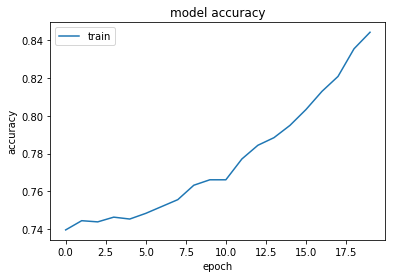

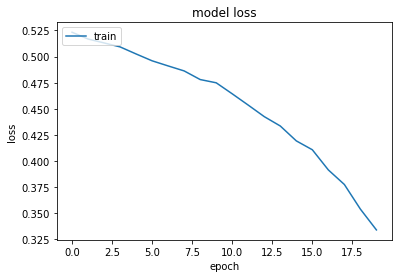

In [22]:
 # summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()